In [1]:
!pip install torchsummary

In [2]:
# Imports

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchsummary
import torchvision.transforms
import cv2
import shutil

import seaborn as sns
import time

from typing import List, Dict, Tuple
from torch import nn, optim
from tqdm import tqdm
from torchvision.datasets.folder import default_loader, DatasetFolder
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_auc_score, cohen_kappa_score
from joblib import dump
from PIL import Image
from torch import Tensor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
root_dir = '/kaggle/input/crop-diseases/data/plant_dataset_original/plant_diseases_images'
model_storage_dir = '/kaggle/working/models_storage'
image_dir = '/kaggle/working/images'

dir_list = ['best_model_state', 'curr_model_state', 'export_models', 'runs', 'saved_models']

if not os.path.exists(model_storage_dir):
    os.makedirs(model_storage_dir, exist_ok=True)
    
if not os.path.exists(image_dir):
    os.makedirs(image_dir, exist_ok=True)
    
for directory in dir_list:
    dir_path = os.path.join(model_storage_dir, directory)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)

In [4]:
# Custom ImageFolder class

def valid_file(filename: str) -> bool:
    """Check if current file has valid extension"""

    return filename.lower().endswith(('.jpg', '.png'))


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folders in a dataset.

    This function searches for subdirectories in the specified directory and returns a list of class names and
    dictionary mapping each class name to its corresponding index.

    The function only includes subdirectories whose names match the regular expression 'apple'. This is intended to
    filter the classes for a specific type of dataset.

    :param directory: The root directory of the training dataset.

    :returns: A tuple containing a list of strings where each string is the name of a class folder and dictionary
    that maps each class name to its corresponding index.

    :raises FileNotFoundError: If no class folders are found in the specified directory.
    """

    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


class CustomImageFolder(torchvision.datasets.DatasetFolder):
    """ Implements custom ImageFolder class that overrides DatasetFolder methods, so it's possible to load only
    specific subdirectories(classes) of the directory instead of the whole directory.

    Enables two valid extensions (.jpg, .png)
    """

    def __init__(self, root, transform=None, target_transform=None, loader=default_loader, is_valid_file=valid_file):
        super().__init__(root, transform=transform, target_transform=target_transform, loader=loader, is_valid_file=is_valid_file)
    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        return find_classes(directory)

In [5]:
# Visualization

def show_dataset(dataset: DatasetFolder | Subset, num_called=0, n=6) -> None:
    """Show grid of images as a single image

    :param dataset: Loaded torchvision dataset
    :param n: Number of rows and columns
    """

    # Transform image from tensor to PILImage
    transform = torchvision.transforms.ToPILImage()
    img = np.vstack([np.hstack([np.asarray(transform(dataset[i][0])) for _ in range(n)])
                     for i in range(n)])
    plt.imshow(img)
    plt.axis('off')
    
    if num_called == 1:
        plt.savefig(image_dir + '/dataset_transform.png')
    elif num_called == 2:
        plt.savefig(image_dir + '/train_dataset_transform.png')
        
    plt.show()
    
    


def show_batch(dataset_loader: DataLoader, num_of_images: int = 9) -> None:
    """Display images before feeding them to the model

    :raises AssertionError: If number of images to display exceeds batch size
    """

    batch_size = dataset_loader.batch_size

    try:
        assert num_of_images < batch_size,\
            f"Number of images to display exceeds batch size: {num_of_images} > {batch_size}"

        data_iter = iter(dataset_loader)
        images, labels = next(data_iter)

        plt.figure(figsize=(10, 10))
        transform = torchvision.transforms.ToPILImage()
        for i in range(num_of_images):
            ax = plt.subplot(3, 3, i + 1)
            img = np.asarray(transform(images[i]))
            plt.imshow(img)
            plt.axis('off')
        
        plt.savefig(image_dir + '/train_loader.png')
        plt.show()
        

    except AssertionError as msg:
        print("Error:", msg)


def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, class_names: List[str]) -> None:
    """Plot the confusion matrix using a heatmap.

   :param y_true: True labels of the test set.
   :param y_pred: Predicted labels of the test set.
   :param class_names: List of class names.
   """

    fig, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names,
                                            normalize='true', xticks_rotation="vertical",
    
                                            ax=ax, colorbar=False)
    plt.savefig(image_dir + '/confusion_matrix.png')
    plt.show(block=False)
    

        
def plot_classification_report(y_true: np.ndarray, y_pred: np.ndarray, class_names: List[str]) -> None:
    """Plot a heatmap visualization of a classification report.

    :param y_true: True labels of the test set .
    :param y_pred: Predicted labels of the test set.
    :param class_names: A list of class names corresponding to the labels.
    """

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df = df.drop(['support'], axis=1)
    sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Classification Report Heatmap')
    plt.savefig(image_dir + '/classification_report_heatmap.png')
    plt.show(block=False)

In [6]:
# Util functions

def loader_shape(dataset_loader: DataLoader) -> Tuple[torch.Size, torch.Size]:
    """Print shape of loaded dataset

    :returns: Tuple of tensor shapes (images, labels)
    """

    data_iter = iter(dataset_loader)
    images, labels = next(data_iter)

    return images.shape, labels.shape


def get_device() -> torch.device:
    """Get the device for running PyTorch computations.

    :returns: torch.device: The selected device (CPU or GPU).
    """

    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")

    return device


def stratify_split(dataset: CustomImageFolder) -> Tuple[Subset, Subset, Subset]:
    """Split a dataset into training, validation, and test subsets while preserving class distribution.

    :param: dataset: The dataset to be split.
    :returns: The training, validation, and test subsets.
    """

    # Split the dataset the to ratio of 80/20
    train_size = int(len(dataset) * 0.8)
    val_size = int(len(dataset) * 0.1)
    test_size = len(dataset) - train_size - val_size

    # Converts the dataset targets to a numpy array
    targets = np.array(dataset.targets)

    # Splits the indices into train and temp sets, stratifying based on targets
    train_idx, temp_idx = train_test_split(
        np.arange(len(dataset)),
        test_size=val_size + test_size,
        shuffle=True,
        stratify=targets,
        random_state=seed
    )

    # Split the temp indices into validation and test sets
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=test_size,
        shuffle=True,
        stratify=targets[temp_idx],
        random_state=seed
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    test_dataset = Subset(dataset, test_idx)

    return train_dataset, val_dataset, test_dataset


def custom_clahe_transform(img: Image) -> Image:
    """Apply custom Contrast Limited Adaptive Histogram Equalization (CLAHE) transformation to an image.

    :param img: The input image to be transformed.
    :returns: The transformed image.
    """

    transform = CustomCLAHE(clip_limit=2.0, tile_grid_size=(8, 8))
    return transform(img)

In [7]:
# Util classes

class FocalLoss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, num_classes=4):
        """Focal loss for multiclass classification.

        :param alpha: Weighting factor, positive class samples are given four times less weight than negative class samples.
        :param gamma: Focusing parameter, gamma > 1 increases emphasis on correctly classifying challenging scenarios.
        :param num_classes: Number of classes.
        """
        super(FocalLoss, self).__init__()

        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes

    def forward(self, cls_preds: Tensor, cls_targets: Tensor) -> Tensor:
        """Compute focal loss between cls_preds and cls_targets

        :param cls_preds: predicted class probabilities, sized [batch_size, num_classes]
        :param cls_targets: target class labels, sized [batch_size, num_classes]

        :returns: focal loss
        """

        # Converts target labels to one-hot encoded values
        t = F.one_hot(cls_targets, self.num_classes).float()  # [batch_size, num_classes]
        t = t.to(cls_preds.device)

        # Small value to avoid numerical instability
        epsilon = 1e-8

        p = torch.clamp(cls_preds.softmax(dim=1), min=epsilon, max=1 - epsilon)

        # Compute focal loss
        focal_loss = -self.alpha * (t * torch.log(p + epsilon) + (1 - t) * torch.log(1 - p + epsilon))
        focal_loss = focal_loss.sum()

        loss = focal_loss.mean()

        return loss
    
    
class CustomCLAHE(object):
    def __init__(self, clip_limit: float = 2.0, tile_grid_size: Tuple[int, int] = (8, 8)):
        """Initializes an object of CustomCLAHE class with specified parameters.

        :param clip_limit: The contrast limit.
        :param tile_grid_size: The size of the grid.
        """

        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img: Image) -> Image:
        """Applies Contrast Limited Adaptive Histogram Equalization to the input image.

        :param img: The input image.
        :returns: The equalized image.
        """

        img = np.array(img)

        # Converts the image from BGR to LAB color space
        lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l_channel, a_channel, b_channel = cv2.split(lab_image)

        # Applies CLAHE to L channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        equalized_l_channel = clahe.apply(l_channel)

        # Merges the equalized L channel with original a and b channels
        equalized_lab_image = cv2.merge([equalized_l_channel, a_channel, b_channel])

        # Converts the equalized LAB image back to BGR color space
        equalized_bgr_image = cv2.cvtColor(equalized_lab_image, cv2.COLOR_LAB2BGR)

        return Image.fromarray(equalized_bgr_image)

In [8]:
# LR_ASK

class LR_ASK:
    def __init__(self, model: nn.Module, optimizer: optim.Optimizer, epochs: int, ask_epoch: int):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask = True
        self.lowest_vloss = float('inf')
        self.best_weights = model.state_dict()
        self.best_epoch = 1
        self.start_time = None

    def on_train_begin(self) -> None:
        """Method called at the beginning of the training process, checks the ask_epoch and epochs values to determine
        the behavior of training
        """

        if self.ask_epoch == 0:
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1

        if self.ask_epoch >= self.epochs:
            print('Ask_epoch >= epochs, will train for', self.epochs, 'epochs', flush=True)
            self.ask = False
        elif self.epochs == 1:
            self.ask = False
        else:
            print('Training will proceed until epoch', self.ask_epoch,
                  'then you will be asked to enter H(h) to halt training or enter an integer'
                  ' to continue training for n number of epochs')

        self.start_time = time.time()

    def on_train_end(self) -> None:
        """Called at the end of the training process, loads the weights of the model with the lowest
        validation loss
        """

        print('Loading model with weights from epoch', self.best_epoch)
        self.model.load_state_dict(self.best_weights)

        train_duration = time.time() - self.start_time
        hours = int(train_duration // 3600)
        minutes = int((train_duration % 3600) // 60)
        seconds = train_duration % 60

        msg = f'Training time: {hours:02d}h:{minutes:02d}m:{seconds:02.0f}s'
        print(msg, flush=True)

    def on_epoch_end(self, epoch: int, val_loss: Tensor):
        """Called at the end of each training epoch, receives the current epoch number
        and the validation loss tensor. Saves the best weights if v_loss is lower.
        """

        # Extracts the scalar value from validation loss tensor
        v_loss = val_loss.item()
        if v_loss < self.lowest_vloss:
            self.lowest_vloss = v_loss
            self.best_weights = self.model.state_dict()
            self.best_epoch = epoch + 1

            print(f'\nValidation loss of {v_loss:.4f} is below lowest loss,'
                  f' saving weights from epoch {str(epoch + 1)} as best weights')
        else:
            print(f'\nValidation loss of {v_loss:.4f} is above lowest loss of {self.lowest_vloss:.4f}'
                  f' keeping weights from epoch {str(self.best_epoch)} as best weights')

        if self.ask and epoch + 1 == self.ask_epoch:
            print('\nEnter H(h) to end training or enter an integer for the number of additional epochs to run')
            ans = input()

            if ans == 'H' or ans == 'h':
                print(f'You entered {ans}, training halted on epoch {epoch + 1}, due to user input\n', flush=True)
                raise KeyboardInterrupt
            else:
                self.ask_epoch += int(ans)
                if self.ask_epoch > self.epochs:
                    print('\nYou specified maximum epochs as', self.epochs,
                          'cannot train for', self.ask_epoch, flush=True)
                else:
                    print(f'You entered {ans}, training will continue to epoch {self.ask_epoch}', flush=True)

                    lr = self.optimizer.param_groups[0]['lr']
                    print(f'Current LR is {lr}, enter C(c) to keep this LR or enter a float number for a new LR')

                    ans = input()
                    if ans == 'C' or ans == 'c':
                        print(f'Keeping current LR of {lr}\n')
                    else:
                        new_lr = float(ans)
                        for param_group in self.optimizer.param_groups:
                            param_group['lr'] = new_lr
                        print('Changing LR to\n', ans)

In [9]:
# Model

import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor


class ConvBlock(nn.Module):
    """Convolutional block with two 3x3 convolutional layers followed by batch normalization layers and max pooling."""

    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_channels)

        self.conv2 = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def conv_block(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        return x

    def forward(self, x):
        """Applies the convolutional block to the input tensor x"""

        return self.conv_block(x)


class ResidualBlock(nn.Module):
    """Residual block with two convolutions followed by batch normalization layers"""

    def __init__(self, in_channels: int, hidden_channels: int,  out_channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_channels)

        self.conv2 = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def residual_block(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = F.relu(self.bn2(self.conv2(x1)))
        return x2 + x

    def forward(self, x): return self.residual_block(x)


class LinearBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, after_conv: bool = False):
        super().__init__()

        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_channels * 7 * 7, out_channels) if after_conv else nn.Linear(in_channels, out_channels)
        self.bn1 = nn.BatchNorm1d(out_channels)

    def linear_block(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        return x

    def forward(self, x): return self.linear_block(x)


class ResModel(nn.Module):

    def __init__(self):
        super(ResModel, self).__init__()

        self.conv1 = ConvBlock(3, 32, 32)
        self.res1 = ResidualBlock(32, 32, 32)

        self.conv2 = ConvBlock(32, 64, 64)
        self.res2 = ResidualBlock(64, 64, 64)

        self.conv3 = ConvBlock(64, 128, 128)
        self.res3 = ResidualBlock(128, 128, 128)

        self.conv4 = ConvBlock(128, 256, 256)
        self.res4 = ResidualBlock(256, 256, 256)

        self.conv5 = ConvBlock(256, 512, 512)
        self.res5 = ResidualBlock(512, 512, 512)

        self.fc1 = LinearBlock(512, 1024, after_conv=True)
        self.fc2 = LinearBlock(1024, 1024)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1024, 32)
        )

    def forward(self, x: Tensor) -> Tensor:
        # Conv blocks and residual blocks
        x = self.conv1(x)
        x = self.res1(x)

        x = self.conv2(x)
        x = self.res2(x)

        x = self.conv3(x)
        x = self.res3(x)

        x = self.conv4(x)
        x = self.res4(x)

        x = self.conv5(x)
        x = self.res5(x)

        # Linear blocks
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        x = self.fc2(x)

        x = self.classifier(x)
        x = F.log_softmax(x, dim=1)
        return x


In [10]:
# Config
batch_size = 32
epochs = 22
seed = 255

focal_loss = {
    'alpha': 0.50,
    'gamma': 1.75
}

adamax_lr = 0.001
adamax_weight_decay = 0.001

torch.manual_seed(seed)

cuda


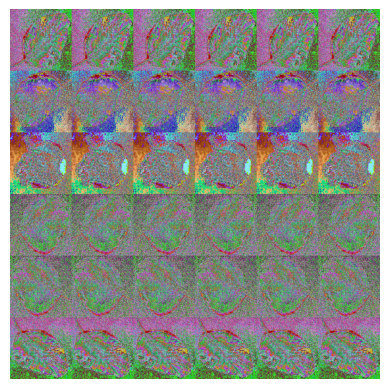

Number of training samples: 76424
Number of validation samples: 9553
Number of test samples: 9553


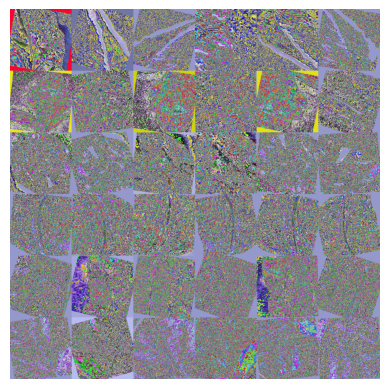

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


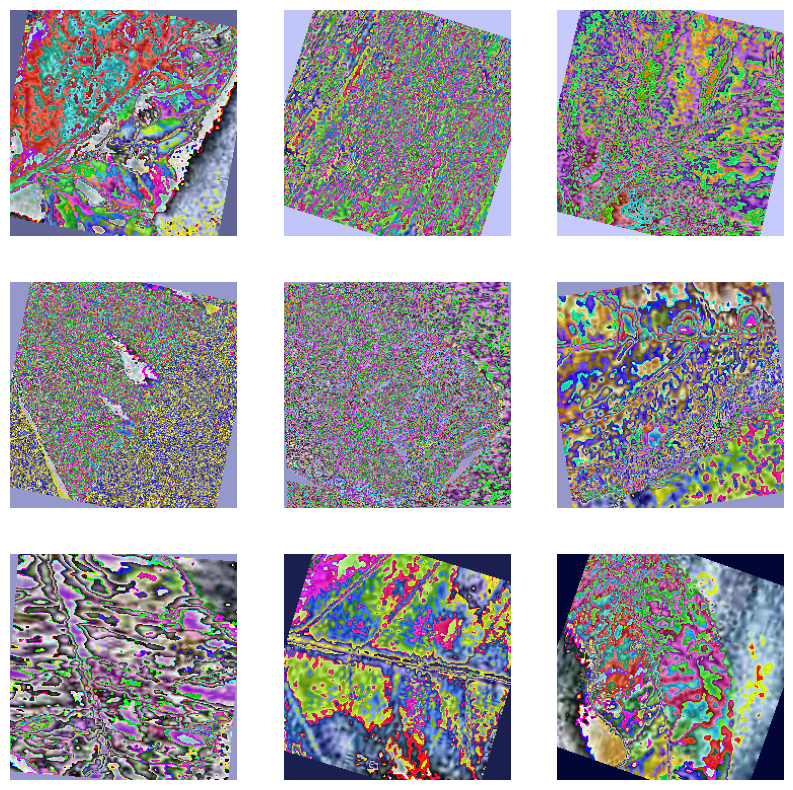

In [11]:
# Preprocessing
device = get_device()
print(device)

writer = SummaryWriter(model_storage_dir + '/runs/model_01')

dataset_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.46445759, 0.49094302, 0.41258632), (0.1741543, 0.14767326, 0.19304359))
])

dump(dataset_transforms, model_storage_dir + '/saved_models/transform.joblib', compress=True)

dataset = CustomImageFolder(root=root_dir, loader=default_loader, transform=dataset_transforms)

num_called_show_dataset = 1
show_dataset(dataset, num_called_show_dataset)

class_names = dataset.classes
num_classes = len(dataset.classes)

train_dataset, val_dataset, test_dataset = stratify_split(dataset)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(custom_clahe_transform),  # increases contrast in a smart way
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(20, interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                                          expand=False),
    torchvision.transforms.ColorJitter(brightness=.05, contrast=0.5, saturation=.05, hue=.05),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset.dataset.transform = train_transforms

num_called_show_dataset += 1
show_dataset(train_dataset, num_called_show_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                           num_workers=2, pin_memory=True,
                                           generator=torch.Generator().manual_seed(seed))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                         num_workers=2, pin_memory=True,
                                         generator=torch.Generator().manual_seed(seed))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          num_workers=2, pin_memory=True,
                                          generator=torch.Generator().manual_seed(seed))

images_shape, labels_shape = loader_shape(train_loader)
print(f'Images shape: {images_shape}\nLabels shape: {labels_shape}')

show_batch(train_loader)

In [12]:
# Logging

log_file_path = '/kaggle/working/log.txt'
log_file = open(log_file_path, 'w')

In [13]:
# Train

model = ResModel().to(device)
# torchsummary.summary(model, (3, 224, 224), batch_size=batch_size)

# loss_fn = nn.NLLLoss().to(device)
loss_fn = FocalLoss(alpha=focal_loss['alpha'], gamma=focal_loss['gamma'],
                    num_classes=num_classes).to(device)

optimizer = optim.Adamax(model.parameters(), lr=adamax_lr, weight_decay=adamax_weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=3)

lr_ask_callback = LR_ASK(model, optimizer, epochs, ask_epoch=24)

best_val_loss = float('inf')
loss = None

train_per_epoch = int(len(train_dataset) / batch_size)
lr_ask_callback.on_train_begin()
for e in range(epochs):
    print(f'Learning rate: {scheduler.get_last_lr()[0]}')
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    model.train()

    train_acc = 0
    train_losses = []
    for idx, (images, labels) in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        output = model(images)
        loss = loss_fn(output, labels)

        loss.backward()
        optimizer.step()

        writer.add_scalar('loss', loss.item(), (e * train_per_epoch) + idx)

        # squeeze() removes singleton dimensions, resulting in a 1D tensor representing
        # the predicted class labels for each input sample
        predictions = output.argmax(dim=1, keepdims=True).squeeze()

        correct = (predictions == labels).sum().item()
        accuracy = correct / len(predictions)

        loop.set_description(f"Epoch [{e + 1}/{epochs}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy, refresh=False)
        writer.add_scalar('acc', accuracy, (e * train_per_epoch) + idx)

        train_acc += correct
        train_losses.append(loss.item())
        
    else:
        torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, model_storage_dir + '/curr_model_state/last_train_model_state.pth')

    train_acc /= len(train_dataset)
    train_loss = np.array(train_losses).mean()
    
    print_train_metric = f'Epoch [{e + 1}/{epochs}]: Train accuracy = {train_acc:.4f} Train loss: {train_loss:.4f}'
    log_file.write(print_train_metric)
    log_file.flush()
    print(print_train_metric)

    scheduler.step()

    val_acc = 0.0
    val_losses = []

    # Disables dropout layers and batch normalization layers use population statistics for normalization
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            val_loss = loss_fn(scores, y)
            val_losses.append(val_loss.item())

            # max() function computes maximum value and its corresponding index along dim=1 axis. Returns tensor
            # containing the maximum values and tensor containing the indices of maximum values
            _, predictions = scores.max(1)
            val_acc += (predictions == y).sum().item()

    val_acc /= len(val_dataset)
    val_loss = np.array(val_losses).mean()
    
    print_val_metric = f'Epoch [{e + 1}/{epochs}]: Validation accuracy = {val_acc:.4f} Validation loss: {val_loss:.4f}'
    log_file.write(print_val_metric)
    log_file.flush()
    print(print_val_metric)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }, model_storage_dir + '/curr_model_state/best_val_loss_checkpoint.pth')

    try:
        lr_ask_callback.on_epoch_end(e, val_loss)
    except KeyboardInterrupt:
        break

lr_ask_callback.on_train_end()

log_file.close()

torch.save(model.state_dict(), model_storage_dir + '/saved_models/ResModel.pth')

zip_file_path = '/kaggle/working/output'

shutil.make_archive(zip_file_path, 'zip', '/kaggle/working/')

Training will proceed until epoch 1 then you will be asked to enter H(h) to halt training or enter an integer to continue training for n number of epochs
Learning rate: 0.001


Epoch [1/20]: 100%|██████████| 2389/2389 [16:44<00:00,  2.38it/s, acc=0.5, loss=9.67]  


Epoch [1/20]: Train accuracy = 0.3913 Train loss: 46.2878
Epoch [1/20]: Validation accuracy = 0.5562 Validation loss: 34.8569

Validation loss of 34.8569 is below lowest loss, saving weights from epoch 1 as best weights

Enter H(h) to end training or enter an integer for the number of additional epochs to run


 h


You entered h, training halted on epoch 1, due to user input

Loading model with weights from epoch 1
Training time: 00h:19m:09s


'/kaggle/working/output.zip'

In [14]:
# Test

num_correct = 0
num_samples = 0
y_true, y_pred, y_score = [], [], []

model.eval()
with torch.no_grad():
    for x, y in test_loader:  # images, labels
        x = x.to(device=device)
        y = y.to(device=device)

        scores = model(x)
        _, predictions = scores.max(1)

        num_correct += (predictions == y).sum()
        num_samples += predictions.size(0)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        y_score.extend(scores.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    # axis=0: column-wise sum, axis=1: row-wise sum
    y_prob = np.exp(y_score) / np.sum(np.exp(y_score), axis=1, keepdims=True)

    print(f'Number of correct {num_correct} of total {num_samples} with accuracy of'
          f' {float(num_correct) / float(num_samples) * 100:.2f}%\n')

    # Measures the model's ability to distinguish between the positive and negative classes,
    # 'ovr' treats one class as positive and the remaining classes as negative
    print(f'Area under the ROC curve: {roc_auc_score(y_true, y_prob, multi_class="ovr")}')

    # Provides a measure of agreement that is adjusted for the possibility of agreement occurring by chance
    print(f'Cohen kappa score: {cohen_kappa_score(y_true, y_pred)}')

Number of correct 5582 of total 9553 with accuracy of 58.43%

Area under the ROC curve: 0.9711069647156719
Cohen kappa score: 0.5687789493717119


In [ ]:
# Analysis

plot_confusion_matrix(y_true, y_pred, class_names)
plot_classification_report(y_true, y_pred, class_names)